## Flowers Recognition 

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United 
Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light 
variations. In addition, there are categories that have large variations within the category and several very 
similar categories. 
The dataset is divided into a training set, a validation set and a test set. The training set and validation set 
each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 
6149 images (minimum 20 per class). Some tasks to consider: 
1. Modify some previously published architectures e.g., increase the network depth, reducing their 
parameters,  etc.  Explore  more  advanced  techniques  such  as  deformable  convolution,  dilated 
convolution (dilation>1) or visual prompt tuning for Transformers. 
2. Analyze the results of using fewer training images, i.e., few-shot learning 
3. Use  more  advanced  transformation  techniques  such  as  MixUp  (see  the  original  paper  and  its 
PyTorch implementation here) 
4. Try more advanced loss function such as triplet loss

In [1]:
import platform
# Requires virtual env to be set up first.
if platform.system() == "Darwin":  # macOS
    %pip install -r requirements_mac.txt
else:
    %pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. Environment Setup

This section setups the environment by doing the following:
1. Importing the dependencies
2. Checking if CUDA/mps is available on device running this notebook
3. Setting up data and output folder to store downloaded dataset and outputs
4. Setting up of transforms for data augmentation
5. Downloading of datasets after transforms are initialized
6. Setting up of hyper parameters for training
7. Creation of dataloaders and visualizing data

### 1. Importing the dependencies

In [2]:
# Import necessary libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import pandas as pd

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary  # For model architecture visualization

# Custom utility files
import src.data_utils as data_utils
import src.visualization as visualization
import src.model_utils as model_utils

# Sets default seeds to 42 for reproducibility
data_utils.set_seeds()

### 2. Checking if CUDA/mps is available

In [3]:
# Set the device based on availability of MPS (macOS), CUDA, or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


### 3. Setting up data and output folders to store downloaded dataset and output later on

In [4]:
# Define the data directories to store dataset and outputs
data_dir = "./data"
output_dir = "./output" 
save_dir = output_dir + "/saved_models"  # Directory to save trained models

# Create directories if they do not exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### 4. Image Transforms and Augmentation
In the training transform, it is normalized to those values instead of (0.5, 0.5, 0.5) for both std and mean as it is common practice and was calculated based on millions of images. So we will try that for now.

Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [5]:
data_transforms = data_utils.get_data_transforms()
display(data_transforms)

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.2)
     RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val_test': Compose(
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

### 5. Dataset Downloading
- Load the Oxford Flowers 102 dataset which is split into the following:
  - Training : 10 image per class (1020 images)
  - Validation : 10 image per class (1020 images)
  - Test set : remaining images (6149 images)

In [6]:
# Download the dataset
flowers_dataset = data_utils.load_flowers102_dataset(data_dir)
display(flowers_dataset)

Train set size: 1020
Validation set size: 1020
Test set size: 6149


{'train': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.2)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                T

The actual labels were acquired from https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1.
We use this to map the actual label to the flower name for better visualisation rather than reading something as 'Flower 1' or 'Flower 27'

In [7]:
flower_labels = data_utils.get_flower_labels("flower_labels.txt")
# Convert the labels to a pandas DataFrame
flower_labels_df = pd.DataFrame(flower_labels, columns=["Flower Name"])
display(flower_labels_df)

Flower Name
0                pink primrose
1    hard-leaved pocket orchid
2             canterbury bells
3                    sweet pea
4             english marigold
..                         ...
97             mexican petunia
98                    bromelia
99              blanket flower
100            trumpet creeper
101            blackberry lily

[102 rows x 1 columns]

### 6. Hyperparameters Setup

In [8]:
# Hyperparameters setup
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = 102 # Number of classes in the dataset, Oxford 102 has 102 classes 

### 7. Creation of dataloaders and visualizing data

In [9]:
# Create our dataloaders for batching and iterators
data_loaders = data_utils.create_dataloaders(datasets_dict=flowers_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Store our dataset sizes in a dictionary for easy access
dataset_sizes = {
    'train': len(data_loaders['train'].dataset),
    'val': len(data_loaders['val'].dataset),
    'test': len(data_loaders['test'].dataset)
}
display(dataset_sizes)

{'train': 1020, 'val': 1020, 'test': 6149}

This section visualizes samples from our training dataset, showing the original image, the augmented image as well as an example of the "most augmented" image that has the most "different" feature vector from the original to visualize what a good augmented image would look like. The most augmented image is just an example given our initial transforms.

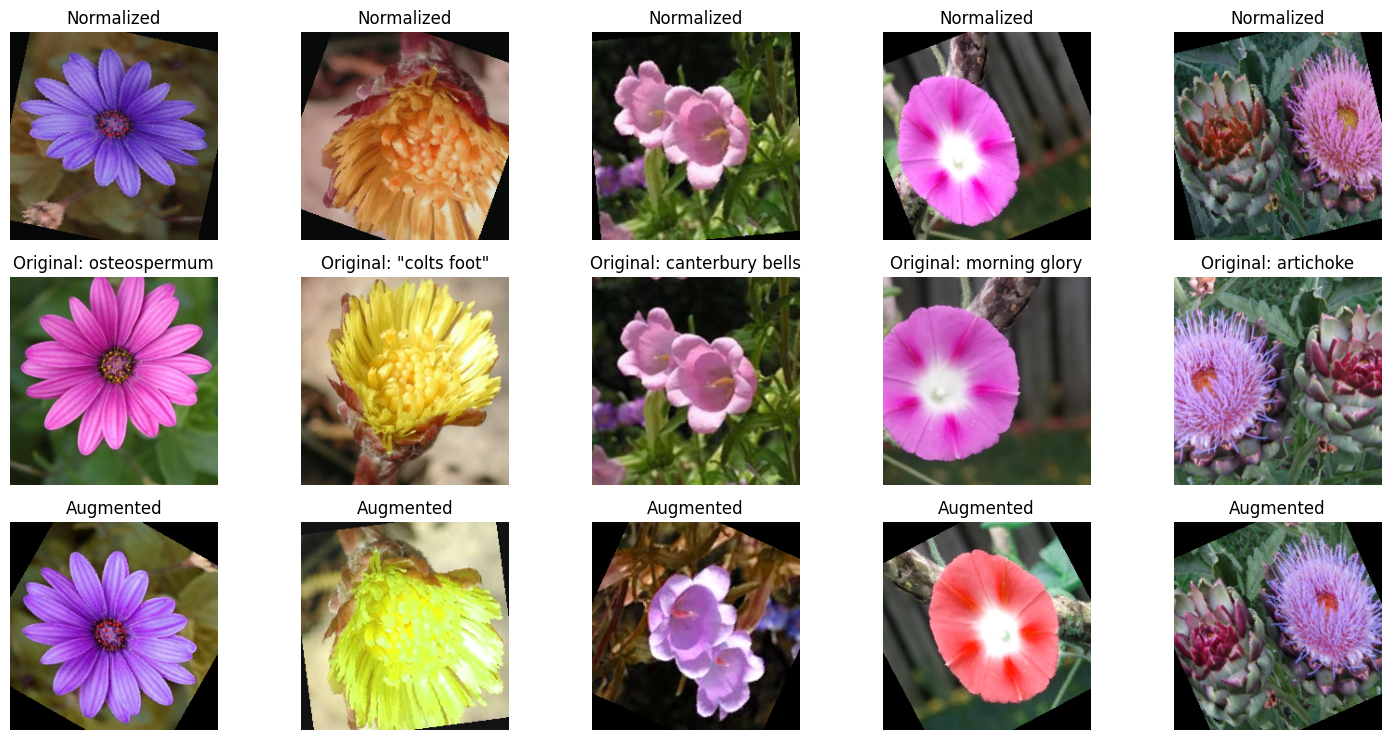

In [10]:
# Visualize a few samples from the training dataset
visualization.visualize_dataset_samples(flowers_dataset['train'], flower_labels, num_samples=5, show_augmented=True)

### 8. Declare Utility Functions

In [11]:
def display_model_architecture(model, device):
    """
    Display model architecture summary including layers and parameters.
    
    Args:
        model (nn.Module): PyTorch model to display
        device (torch.device): Device the model is running on
    
    Returns:
        None: Prints model architecture information
    """
    if hasattr(model, "model_name"):
        print(f"Model Architecture: {model.model_name}")
    else:
        print(f"\nModel Architecture: {model.__class__.__name__}")
    try:
        summary(model, (3, 224, 224), device=device.type)
    except Exception as e:
        print(f"Could not generate detailed summary: {e}")
        print(model)

def display_model_parameters(model):
    """
    Calculate and display parameter statistics for the model.
    
    Args:
        model (nn.Module): PyTorch model to analyze
    
    Returns:
        tuple: (total_params, trainable_params, non_trainable_params)
    """
    # Calculate parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"\nModel Parameter Information:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    
    return total_params, trainable_params, non_trainable_params

## Training and evaluating the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.


The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

### Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset (default is 25).

### Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training Loop**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - Depending on the phase (`train` or `val`), the model is set to the appropriate mode using `model.train()` or `model.eval()`.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - If in the training phase, backpropagation is performed and the optimizer updates the model's parameters.
        - Running statistics like loss and accuracy are computed for each epoch.
        - If in the training phase, the learning rate scheduler adjusts the learning rate.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

By using this function, one can easily train and evaluate a neural network model, ensuring that the best version of the model (in terms of validation accuracy) is retained.



In [12]:
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    """
    Train the model
    
    Args:
        model: The model to train
        criterion: Loss function
        optimizer: Optimizer for updating weights
        scheduler: Learning rate scheduler
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        dataset_sizes: Dictionary with sizes of 'train' and 'val' datasets
        num_epochs: Number of epochs to train
        
    Returns:
        model: Trained model with best weights
    """
    since = time.time()
    device = next(model.parameters()).device
    
    # Track training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                if device.type == 'mps':
                    # Mps does not support float64
                    epoch_acc = running_corrects.float() / dataset_sizes[phase]
                else:
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store history
                if phase == 'train':
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                else:
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc.item())
                    # Update scheduler based on validation loss
                    scheduler.step(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, history

In [13]:
def evaluate_model(model, criterion, data_loader):
    """
    Evaluate the model on the test set
    
    Args:
        model: The model to evaluate
        criterion: Loss function
        data_loader: DataLoader for the test dataset
        
    Returns:
        test_loss: The average loss on the test set
        test_acc: The accuracy on the test set
        all_preds: List of all predictions
        all_labels: List of all true labels
    """
    device = next(model.parameters()).device
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # No gradient computation needed for evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test loss and accuracy
    dataset_size = len(data_loader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.float() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

### Training Setup
This section sets up the optimizer, criterion, and scheduler that will be used for the experiments.

We use CrossEntropyLoss as our criterion since we're dealing with multi-class classification. For optimization, we use Adam with an initial learning rate of LEARNING_RATE. Adam typically converges faster than SGD for many deep learning tasks by adaptively adjusting the learning rates of individual parameters.

To improve training dynamics, we implement a ReduceLROnPlateau scheduler, which reduces the learning rate by a factor of 0.1 when the validation loss stops improving for 3 consecutive epochs. This approach helps the model converge more effectively, especially when training reaches a plateau.

In [14]:
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

def get_optimizer_and_scheduler(model):
    # Using Adam optimizer
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # Learning rate scheduler - reduce learning rate when validation loss plateaus
    # patience=3: wait for 3 epochs with no improvement before reducing LR
    # factor=0.1: multiply learning rate by 0.1 when reducing
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6,threshold=0.01, verbose=True)
    return optimizer, scheduler

In [15]:
# Add code for loading and training models
def load_or_train_model(model_name, model_class, save_dir, device, **kwargs):  
    # Attempt to load from previous
    if model_utils.check_model_exists(model_name =model_name, save_dir=save_dir):
        print(f"Loading existing model: {model_name}")
        # Load the pre-trained model and its history
        model, history = model_utils.load_model_and_history(
            model_class=model_class, 
            model_name=model_name, 
            num_classes=NUM_CLASSES, 
            save_dir=save_dir,
            device=device
        )
        
        # Display the architecture and parameters of the loaded model
        display_model_architecture(model, device)
        display_model_parameters(model)
        
        print("Model loaded successfully! Skipping training phase.")
    else:
        print(f"No existing model found. Initializing and training new model: {model_name}")
        
        # Initialize the model using the model class
        model = model_class(**kwargs)
        model = model.to(device)  # Send to GPU if possible
        
        # Show the parameters and architecture of the model
        display_model_architecture(model, device)
        display_model_parameters(model)
        
        # Initialize optimizer and scheduler
        optimizer, scheduler = get_optimizer_and_scheduler(model)
        
        # Train the model
        model, history = train_model(
            model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            dataloaders=data_loaders, 
            dataset_sizes=dataset_sizes, 
            num_epochs=NUM_EPOCHS
        )
        
        # Save the model after training
        model_utils.save_model_and_history(model, history, model_name=model_name, save_dir=save_dir)
        
        print(f"Model trained and saved successfully!")
    
    return model, history

## Model 1: Base CNN Model

In [15]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.base_cnn import BaseCNN

# Initialize the model and history as None first
model_name = "base_cnn"

# Load or train the model
base_cnn, base_cnn_history = load_or_train_model(
    model_name=model_name,
    model_class=BaseCNN,
    save_dir=save_dir,
    device=device
)

No existing model found. Initializing and training new model: base_cnn

Model Architecture: BaseCNN
Could not generate detailed summary: Input device is not valid, please specify 'cuda' or 'cpu'
BaseCNN(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_1): BatchNorm2d(192, eps=

/Users/matthewheng/Documents/y3s2/sc4001_project2/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/32 [00:00<?, ?it/s]

: 

Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 3.0105 Acc: 0.2527
Final Test Accuracy: 0.2527
Final Test Loss: 3.0105


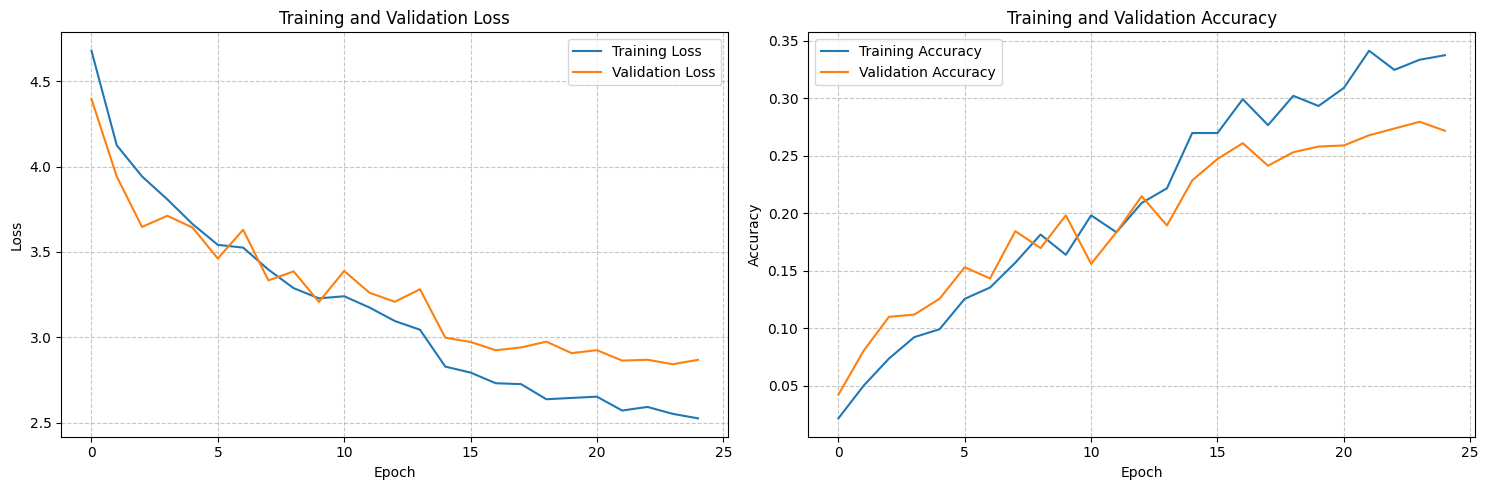

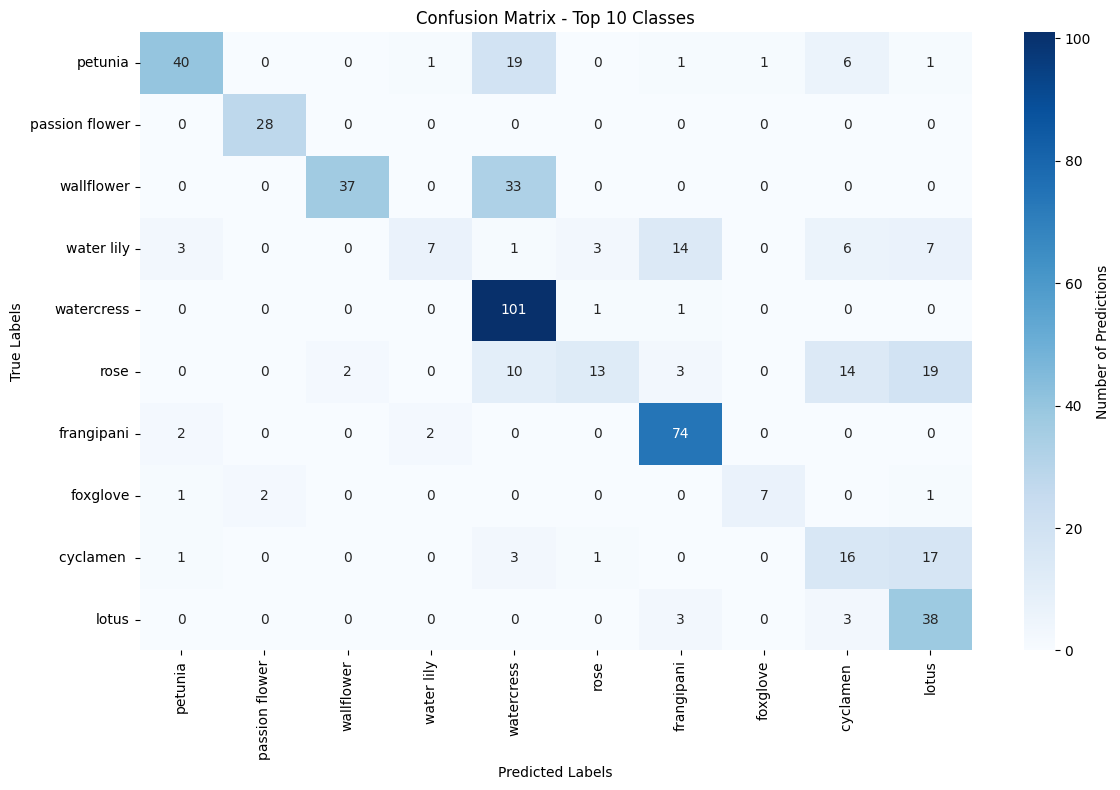

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.85      0.58      0.69        69
passion flower       0.93      1.00      0.97        28
    wallflower       0.95      0.53      0.68        70
    water lily       0.70      0.17      0.27        41
    watercress       0.60      0.98      0.75       103
          rose       0.72      0.21      0.33        61
    frangipani       0.77      0.95      0.85        78
      foxglove       0.88      0.64      0.74        11
     cyclamen        0.36      0.42      0.39        38
         lotus       0.46      0.86      0.60        44

      accuracy                           0.66       543
     macro avg       0.72      0.63      0.63       543
  weighted avg       0.72      0.66      0.64       543



In [ ]:
# Evaluate the model on the test set
base_cnn_test_loss, base_cnn_test_acc, all_preds, all_labels = evaluate_model(base_cnn, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_cnn_test_acc:.4f}")
print(f"Final Test Loss: {base_cnn_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(base_cnn_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

Finding closest images for misclassification 1/5...
Finding closest images for misclassification 2/5...
Finding closest images for misclassification 3/5...
Finding closest images for misclassification 4/5...
Finding closest images for misclassification 5/5...


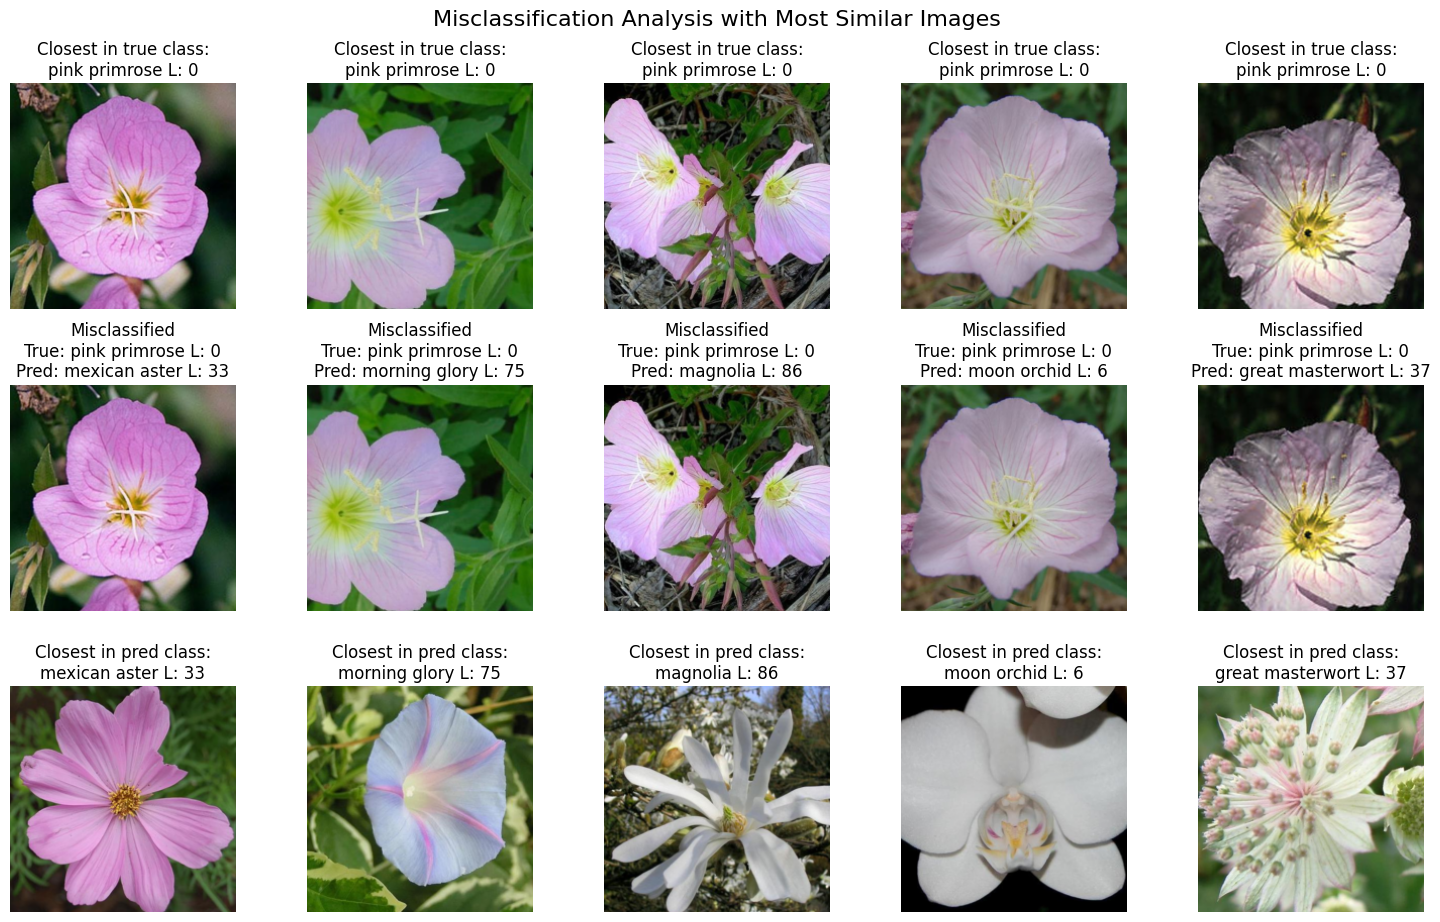

{'unique_true_classes': 1, 'unique_class_pairs': 5, 'total_examples': 5}

In [ ]:
#visualization.visualize_misclassifications_with_closest_images(base_cnn, data_loaders['test'], flower_labels, flowers_dataset['test'])

## Model 2: Pretrained Model: Resnet 18
This is just to compare the performance using a base pre trained model on this dataset with transfer learning. We will update the layers later with deformable and dilated convolutions to perform more analysis.

In [ ]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.base_pretrained_model import BasePretrainedModel

# Initialize the model and history as None first
model_name = "base_resnet18"

# Load or train the model
base_resnet18, resnet18_history = load_or_train_model(
    model_name=model_name,
    model_class=BasePretrainedModel,
    save_dir=save_dir,
    device=device,
    num_classes =NUM_CLASSES,
    freeze_layers=True
)

No existing model found. Initializing and training new model: base_resnet18

Model Architecture: BasePretrainedModel
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]   

c:\Users\isaac\Documents\GitHub\flowers-recognition\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.8209 Acc: 0.0373


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.7804 Acc: 0.2029

Epoch 2/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.4117 Acc: 0.2892


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9751 Acc: 0.4010

Epoch 3/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6733 Acc: 0.4784


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3028 Acc: 0.5863

Epoch 4/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.0243 Acc: 0.6451


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.9437 Acc: 0.5980

Epoch 5/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.5943 Acc: 0.7206


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6170 Acc: 0.6775

Epoch 6/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.4052 Acc: 0.7569


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5230 Acc: 0.6588

Epoch 7/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.1754 Acc: 0.7951


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.3666 Acc: 0.7069

Epoch 8/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.0291 Acc: 0.8176


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.2528 Acc: 0.7127

Epoch 9/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.9148 Acc: 0.8304


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.1826 Acc: 0.7461

Epoch 10/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7867 Acc: 0.8725


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.1600 Acc: 0.7294

Epoch 11/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7667 Acc: 0.8618


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.1413 Acc: 0.7275

Epoch 12/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7094 Acc: 0.8696


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.0403 Acc: 0.7598

Epoch 13/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6414 Acc: 0.8873


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9950 Acc: 0.7775

Epoch 14/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6022 Acc: 0.8873


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9492 Acc: 0.7725

Epoch 15/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5494 Acc: 0.8961


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9566 Acc: 0.7618

Epoch 16/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5293 Acc: 0.9088


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8600 Acc: 0.7882

Epoch 17/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4751 Acc: 0.9186


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8658 Acc: 0.7843

Epoch 18/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4623 Acc: 0.9265


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8739 Acc: 0.7843

Epoch 19/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4288 Acc: 0.9225


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9140 Acc: 0.7765

Epoch 20/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3754 Acc: 0.9402


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8504 Acc: 0.7863

Epoch 21/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3971 Acc: 0.9314


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9225 Acc: 0.7706

Epoch 22/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3810 Acc: 0.9343


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8433 Acc: 0.7863

Epoch 23/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3703 Acc: 0.9235


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8469 Acc: 0.7765

Epoch 24/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3800 Acc: 0.9245


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8328 Acc: 0.7814

Epoch 25/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3343 Acc: 0.9353


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8083 Acc: 0.7882

Training complete in 4m 49s
Best val Acc: 0.788235
Model saved to ./output/saved_models\base_resnet18.pth
Training history saved to ./output/saved_models\base_resnet18_history.json
Model trained and saved successfully!


C:\Users\isaac\AppData\Local\Temp\ipykernel_21076\730607927.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.9571 Acc: 0.7691
Final Test Accuracy: 0.7691
Final Test Loss: 0.9571


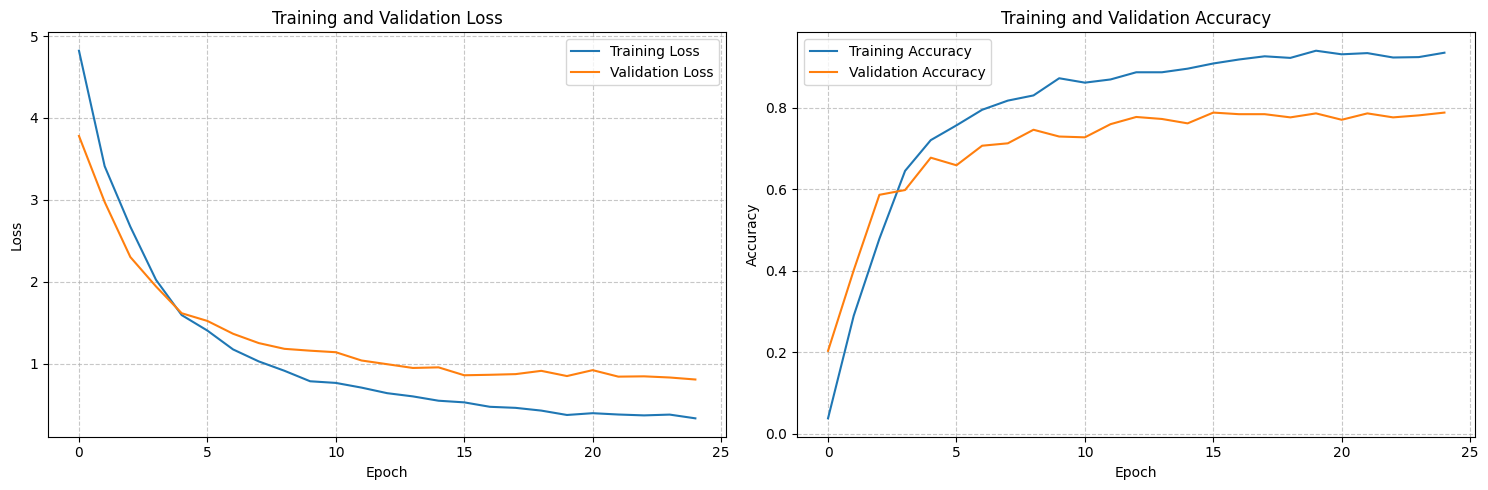

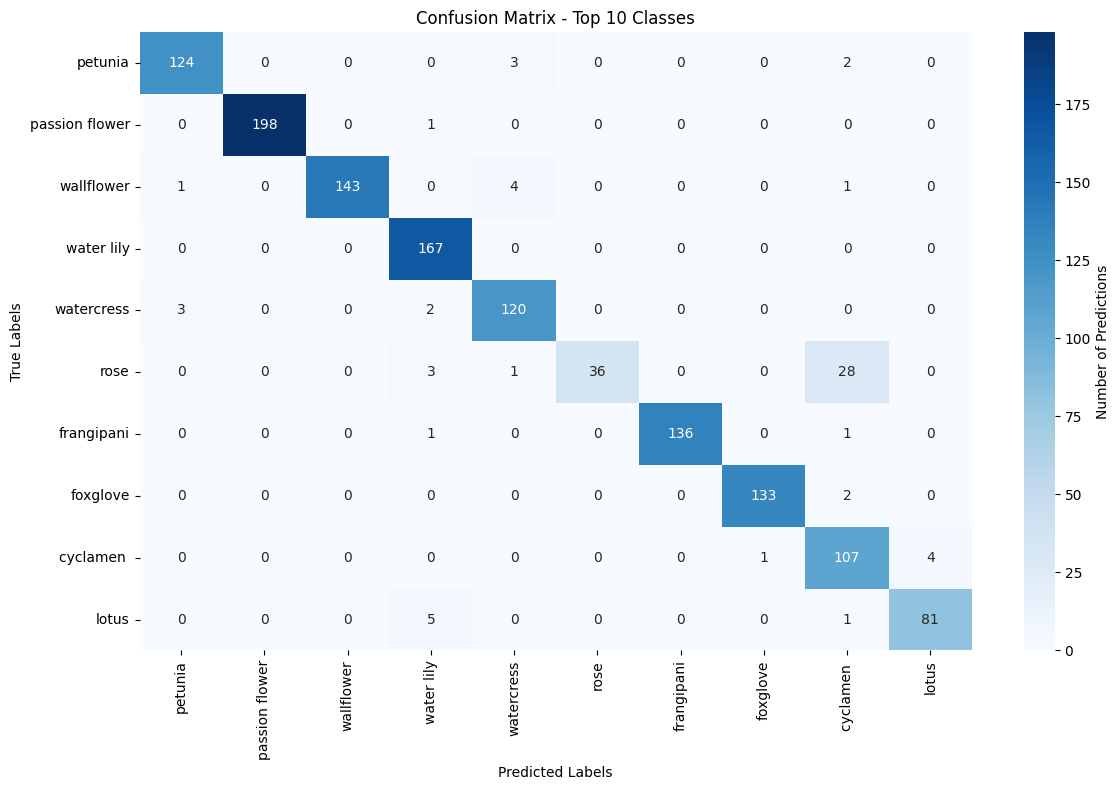

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.97      0.96      0.96       129
passion flower       1.00      0.99      1.00       199
    wallflower       1.00      0.96      0.98       149
    water lily       0.93      1.00      0.97       167
    watercress       0.94      0.96      0.95       125
          rose       1.00      0.53      0.69        68
    frangipani       1.00      0.99      0.99       138
      foxglove       0.99      0.99      0.99       135
     cyclamen        0.75      0.96      0.84       112
         lotus       0.95      0.93      0.94        87

      accuracy                           0.95      1309
     macro avg       0.95      0.93      0.93      1309
  weighted avg       0.96      0.95      0.95      1309



In [ ]:
# Evaluate the resnet18 on the test set
base_resnet18_test_loss, base_resnet18_test_acc, all_preds, all_labels = evaluate_model(base_resnet18, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_resnet18_test_acc:.4f}")
print(f"Final Test Loss: {base_resnet18_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(resnet18_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

Finding closest images for misclassification 1/5...
Finding closest images for misclassification 2/5...
Finding closest images for misclassification 3/5...
Finding closest images for misclassification 4/5...
Finding closest images for misclassification 5/5...


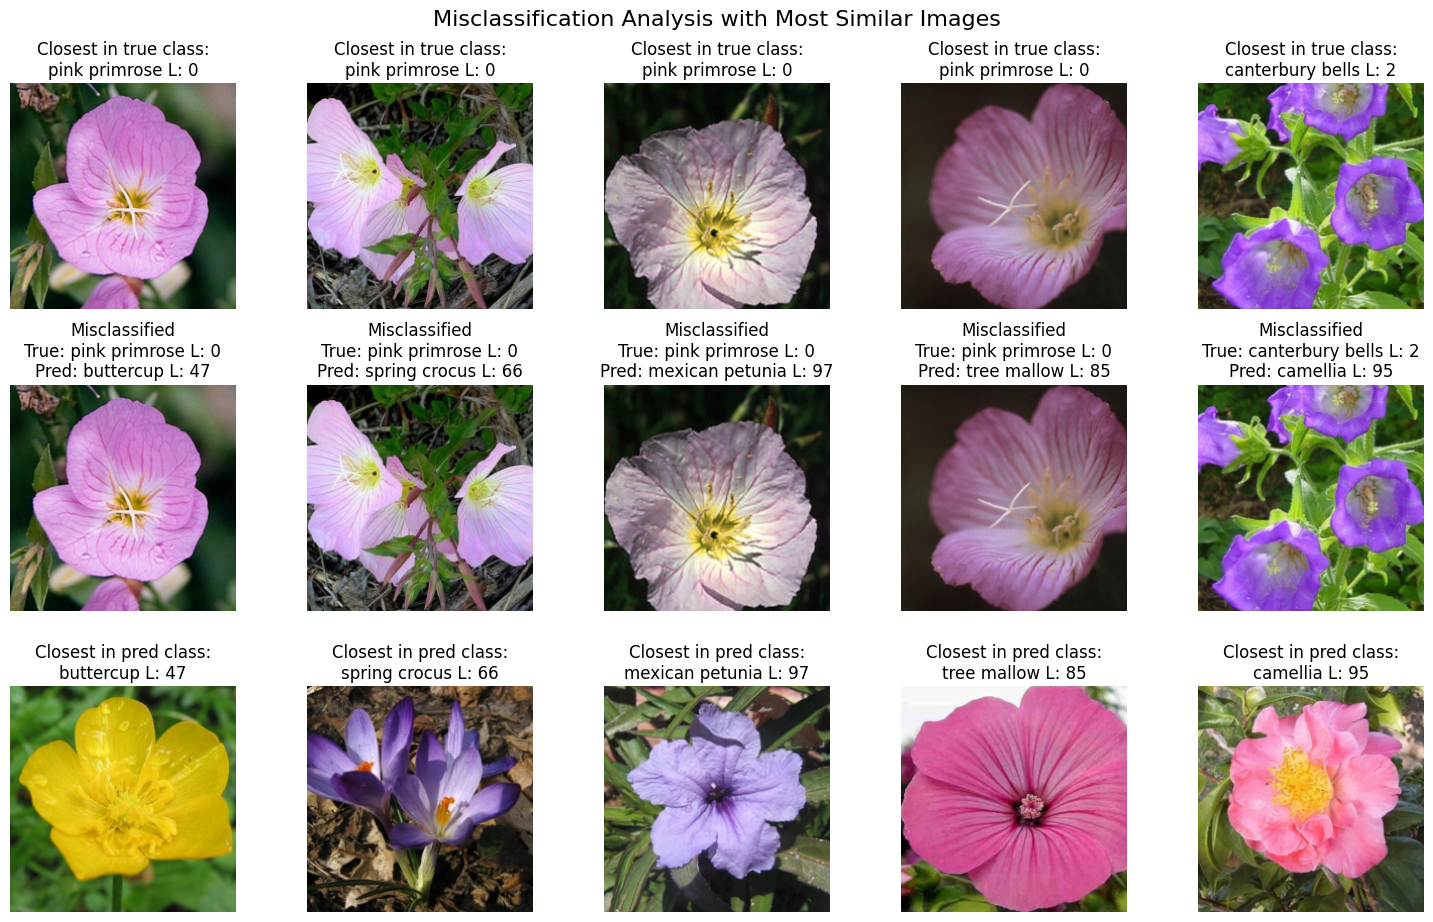

{'unique_true_classes': 2, 'unique_class_pairs': 5, 'total_examples': 5}

In [ ]:
#visualization.visualize_misclassifications_with_closest_images(base_resnet18, data_loaders['test'], flower_labels, flowers_dataset['test'])

## Model 3: Pretrained Model: Resnet 50
In this model, we expect accuracy to be higher as there are more layers, which should help capture the more intricate details of the flowers.

In [ ]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.base_pretrained_model import BasePretrainedModel

# Initialize the model and history as None first
model_name = "base_resnet50"

# Load or train the model
base_resnet50, resnet50_history = load_or_train_model(
    model_name=model_name,
    model_class=BasePretrainedModel,
    save_dir=save_dir,
    device=device
)

No existing model found. Initializing and training new model: base_resnet50

Model Architecture: BasePretrainedModel
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]   

train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.9019 Acc: 0.0216


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 64.8449 Acc: 0.0137

Epoch 2/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.7146 Acc: 0.0039


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 7.9043 Acc: 0.0216

Epoch 3/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.5862 Acc: 0.0167


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.5247 Acc: 0.0225

Epoch 4/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.3142 Acc: 0.0255


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.3686 Acc: 0.0343

Epoch 5/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.1133 Acc: 0.0373


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 9.5727 Acc: 0.0441

Epoch 6/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.8721 Acc: 0.0676


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.0069 Acc: 0.0804

Epoch 7/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.7679 Acc: 0.0755


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.5528 Acc: 0.1069

Epoch 8/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.5807 Acc: 0.0922


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.5250 Acc: 0.1392

Epoch 9/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.4761 Acc: 0.1275


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3438 Acc: 0.1490

Epoch 10/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2090 Acc: 0.1824


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2524 Acc: 0.1941

Epoch 11/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0874 Acc: 0.1941


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.1338 Acc: 0.1912

Epoch 12/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0100 Acc: 0.2118


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 6.2237 Acc: 0.1098

Epoch 13/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.7438 Acc: 0.2618


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9609 Acc: 0.2686

Epoch 14/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6290 Acc: 0.3049


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2329 Acc: 0.2373

Epoch 15/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.4466 Acc: 0.3471


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9490 Acc: 0.2882

Epoch 16/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.3200 Acc: 0.3618


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.0253 Acc: 0.2549

Epoch 17/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.1959 Acc: 0.3912


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.0547 Acc: 0.3039

Epoch 18/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.1164 Acc: 0.4167


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.8187 Acc: 0.3157

Epoch 19/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.0617 Acc: 0.4314


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3867 Acc: 0.3863

Epoch 20/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.8714 Acc: 0.4618


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.7645 Acc: 0.3480

Epoch 21/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.7615 Acc: 0.4912


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3766 Acc: 0.4069

Epoch 22/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.5606 Acc: 0.5520


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.6286 Acc: 0.3873

Epoch 23/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.5274 Acc: 0.5588


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.7206 Acc: 0.3735

Epoch 24/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.4136 Acc: 0.5931


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3246 Acc: 0.4118

Epoch 25/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.2874 Acc: 0.6265


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.0753 Acc: 0.4922

Epoch 26/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.2743 Acc: 0.6196


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.1052 Acc: 0.5020

Epoch 27/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.1386 Acc: 0.6735


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3456 Acc: 0.4608

Epoch 28/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.1351 Acc: 0.6716


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.2445 Acc: 0.5000

Epoch 29/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.0876 Acc: 0.6775


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.2675 Acc: 0.4951

Epoch 30/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.0215 Acc: 0.7020


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.1912 Acc: 0.5137

Epoch 31/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7430 Acc: 0.7824


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5657 Acc: 0.6137

Epoch 32/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5232 Acc: 0.8373


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6578 Acc: 0.6157

Epoch 33/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5419 Acc: 0.8255


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.7655 Acc: 0.6078

Epoch 34/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4801 Acc: 0.8500


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.9054 Acc: 0.6078

Epoch 35/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4665 Acc: 0.8451


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.7651 Acc: 0.6147

Epoch 36/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3962 Acc: 0.8843


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6916 Acc: 0.6294

Epoch 37/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3138 Acc: 0.9108


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5695 Acc: 0.6608

Epoch 38/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2753 Acc: 0.9235


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5792 Acc: 0.6657

Epoch 39/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2727 Acc: 0.9069


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6366 Acc: 0.6539

Epoch 40/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2388 Acc: 0.9314


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5646 Acc: 0.6716

Epoch 41/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2313 Acc: 0.9275


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6302 Acc: 0.6696

Epoch 42/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1918 Acc: 0.9529


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5360 Acc: 0.6931

Epoch 43/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1887 Acc: 0.9539


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6270 Acc: 0.6755

Epoch 44/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1696 Acc: 0.9608


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5797 Acc: 0.6853

Epoch 45/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1544 Acc: 0.9637


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5940 Acc: 0.6882

Epoch 46/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1678 Acc: 0.9559


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6133 Acc: 0.6873

Epoch 47/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1442 Acc: 0.9735


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5953 Acc: 0.6824

Epoch 48/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1523 Acc: 0.9618


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.4972 Acc: 0.7118

Epoch 49/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1105 Acc: 0.9755


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5417 Acc: 0.6882

Epoch 50/50
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1140 Acc: 0.9765


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5367 Acc: 0.6892

Training complete in 11m 38s
Best val Acc: 0.711765


C:\Users\isaac\AppData\Local\Temp\ipykernel_21076\730607927.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Model saved to ./output/saved_models\base_resnet50.pth
Training history saved to ./output/saved_models\base_resnet50_history.json
Model trained and saved successfully!


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 1.7282 Acc: 0.6515
Final Test Accuracy: 0.6515
Final Test Loss: 1.7282


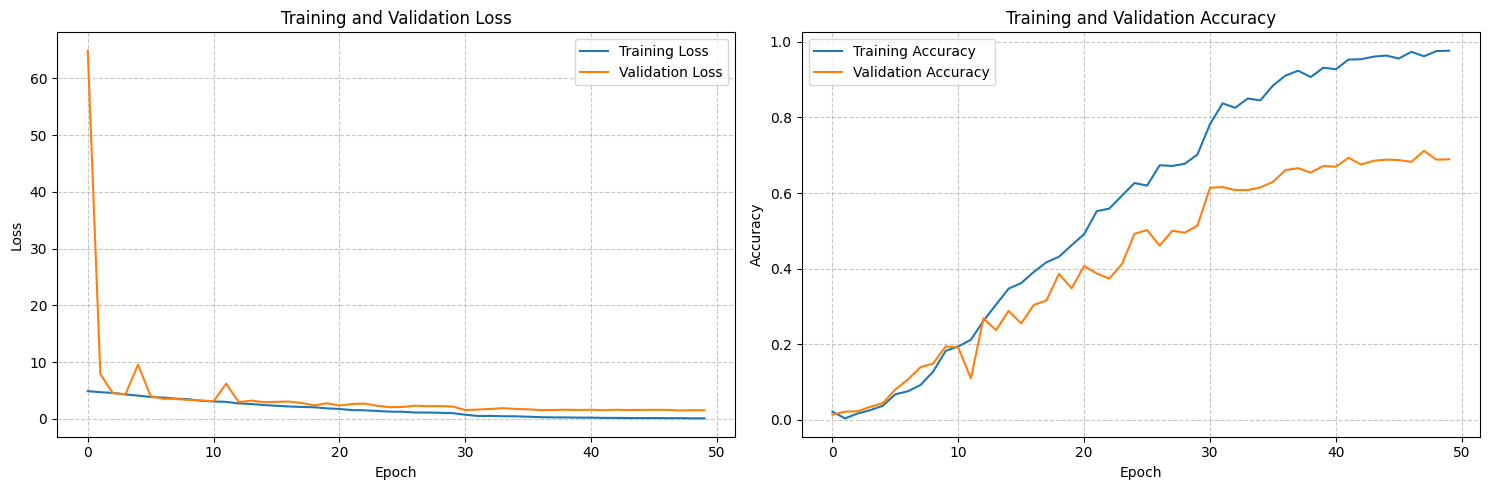

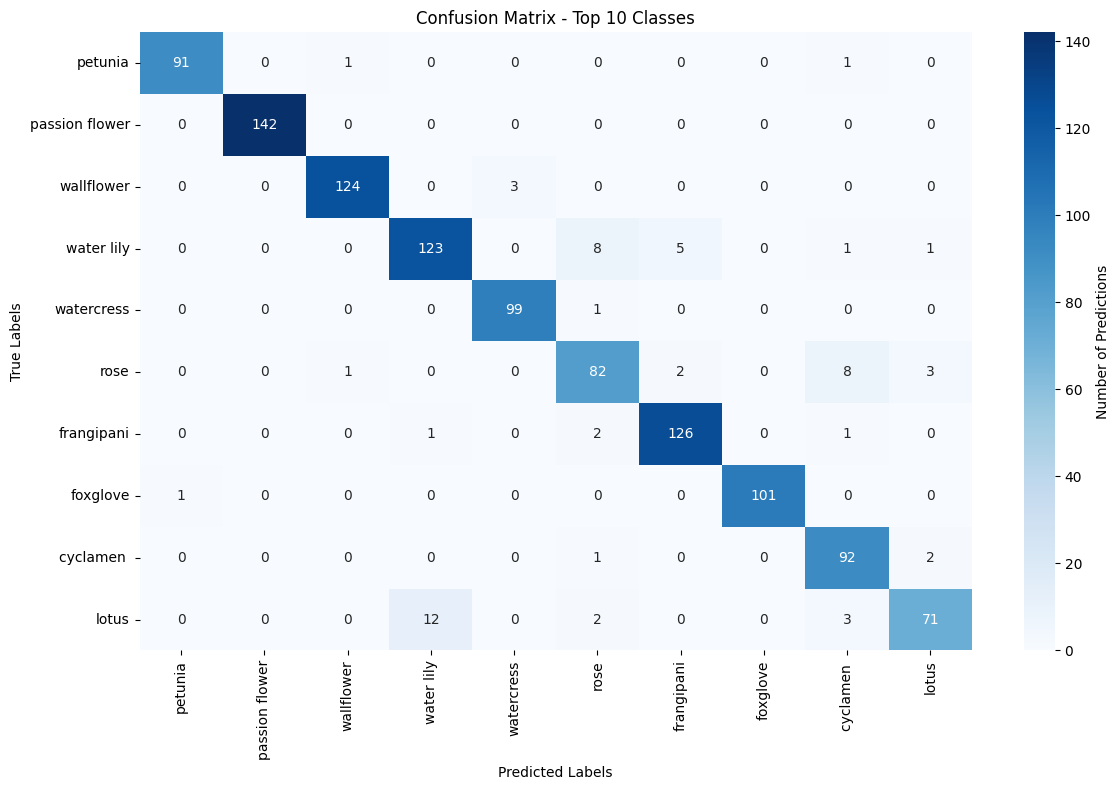

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.99      0.98      0.98        93
passion flower       1.00      1.00      1.00       142
    wallflower       0.98      0.98      0.98       127
    water lily       0.90      0.89      0.90       138
    watercress       0.97      0.99      0.98       100
          rose       0.85      0.85      0.85        96
    frangipani       0.95      0.97      0.96       130
      foxglove       1.00      0.99      1.00       102
     cyclamen        0.87      0.97      0.92        95
         lotus       0.92      0.81      0.86        88

      accuracy                           0.95      1111
     macro avg       0.94      0.94      0.94      1111
  weighted avg       0.95      0.95      0.95      1111



In [ ]:
# Evaluate the resnet50 on the test set
base_resnet50_test_loss, base_resnet50_test_acc, all_preds, all_labels = evaluate_model(base_resnet50, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_resnet50_test_acc:.4f}")
print(f"Final Test Loss: {base_resnet50_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(resnet50_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [20]:
#visualization.visualize_misclassifications_with_closest_images(base_resnet50, data_loaders['test'], flower_labels, flowers_dataset['test'])

## Model 4: Base ViT model - only classification head is trainable

In [16]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.base_vit import BaseViT

# Initialize the model and history as None first
model_name = "base_vit"

# Load or train the model
base_vit, base_vit_history = load_or_train_model(
    model_name=model_name,
    model_class=BaseViT,
    save_dir=save_dir,
    device=device,
    num_classes=NUM_CLASSES
)

No existing model found. Initializing and training new model: base_vit

Model Architecture: BaseViT
Could not generate detailed summary: Input device is not valid, please specify 'cuda' or 'cpu'
BaseViT(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm

/Users/matthewheng/Documents/y3s2/sc4001_project2/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.6900 Acc: 0.0431


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.5013 Acc: 0.2500

Epoch 2/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.9613 Acc: 0.4069


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.9986 Acc: 0.7216

Epoch 3/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.7406 Acc: 0.7206


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.2200 Acc: 0.8559

Epoch 4/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.1284 Acc: 0.8539


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8513 Acc: 0.9059

Epoch 5/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.8030 Acc: 0.9078


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6620 Acc: 0.9284

Training complete in 5m 7s
Best val Acc: 0.928431


/var/folders/ty/0418byqj16v3h38_l5fhk1fc0000gn/T/ipykernel_37004/730607927.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

Model saved to ./output/saved_models/base_vit.pth
Training history saved to ./output/saved_models/base_vit_history.json
Model trained and saved successfully!


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.6710 Acc: 0.9231
Final Test Accuracy: 0.9231
Final Test Loss: 0.6710


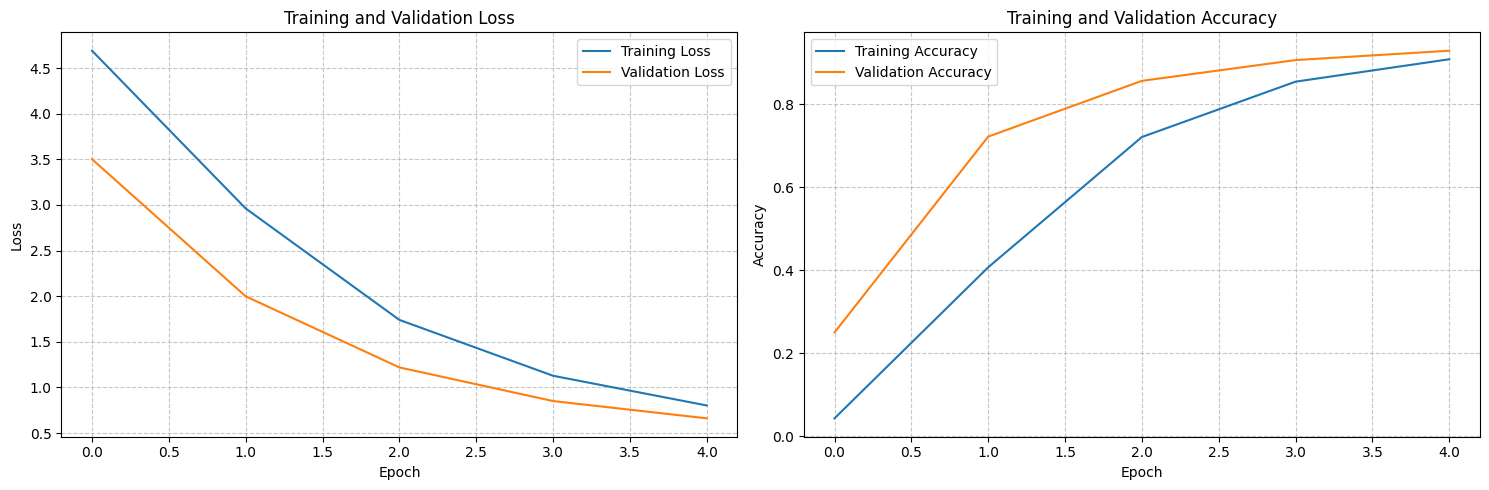

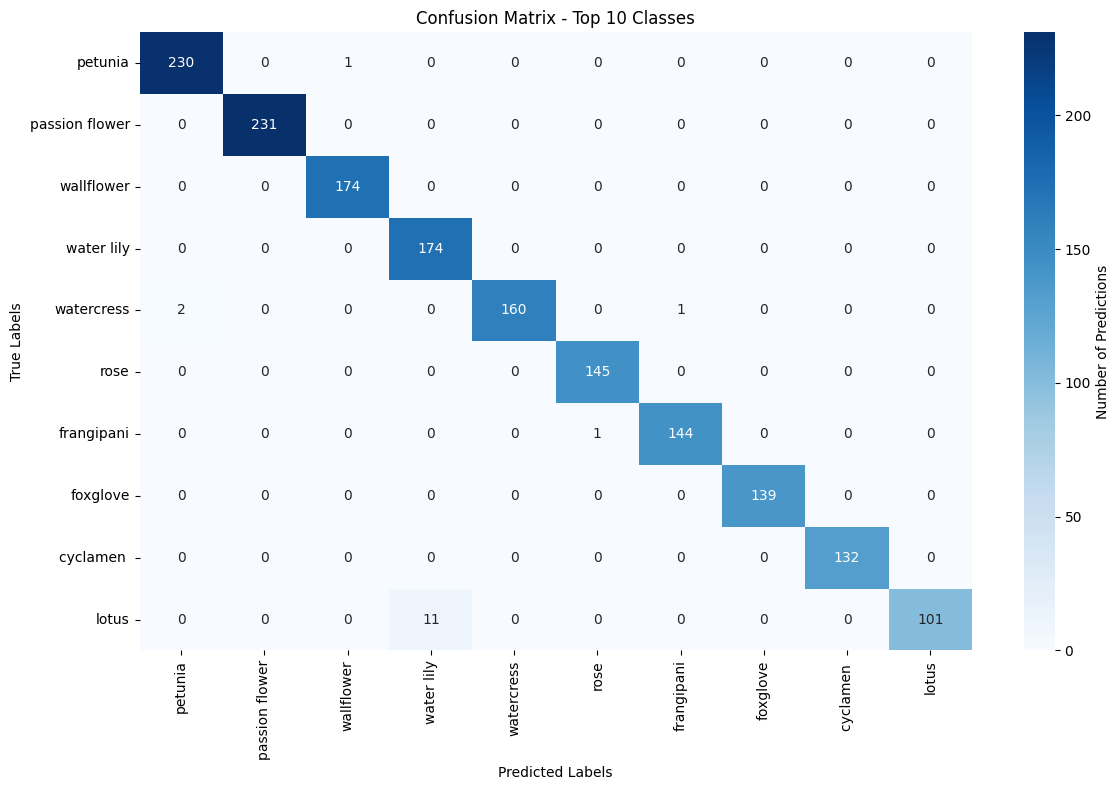

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.99      1.00      0.99       231
passion flower       1.00      1.00      1.00       231
    wallflower       0.99      1.00      1.00       174
    water lily       0.94      1.00      0.97       174
    watercress       1.00      0.98      0.99       163
          rose       0.99      1.00      1.00       145
    frangipani       0.99      0.99      0.99       145
      foxglove       1.00      1.00      1.00       139
     cyclamen        1.00      1.00      1.00       132
         lotus       1.00      0.90      0.95       112

      accuracy                           0.99      1646
     macro avg       0.99      0.99      0.99      1646
  weighted avg       0.99      0.99      0.99      1646



In [17]:
# Evaluate the vit on the test set
base_vit_test_loss, base_vit_test_acc, all_preds, all_labels = evaluate_model(base_vit, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_vit_test_acc:.4f}")
print(f"Final Test Loss: {base_vit_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(base_vit_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

## Model 5: ViT model - Prompt Tuning 


In [ ]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.vpt_vit import VPT

# Initialize the model and history as None first
model_name = "vit_prompt_tuning"

# Load or train the model
vit_prompt_tuned, vit_prompt_tuned_history = load_or_train_model(
    model_name=model_name,
    model_class=VPT,
    save_dir=save_dir,
    device=device,
    num_classes=NUM_CLASSES
)

No existing model found. Initializing and training new model: vit_prompt_tuning

Model Architecture: VPT
Could not generate detailed summary: Input device is not valid, please specify 'cuda' or 'cpu'
VPT(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2

/Users/matthewheng/Documents/y3s2/sc4001_project2/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.7160 Acc: 0.0451


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6737 Acc: 0.1980

Epoch 2/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0604 Acc: 0.3873


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.2805 Acc: 0.6304

Epoch 3/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.8984 Acc: 0.6961


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.4231 Acc: 0.8147

Epoch 4/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.2389 Acc: 0.8127


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.0021 Acc: 0.8755

Epoch 5/5
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.9074 Acc: 0.8814


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.7640 Acc: 0.9157

Training complete in 6m 30s
Best val Acc: 0.915686


/var/folders/ty/0418byqj16v3h38_l5fhk1fc0000gn/T/ipykernel_37004/730607927.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

Model saved to ./output/saved_models/vit_prompt_tuning.pth
Training history saved to ./output/saved_models/vit_prompt_tuning_history.json
Model trained and saved successfully!


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.7662 Acc: 0.9156
Final Test Accuracy: 0.9156
Final Test Loss: 0.7662


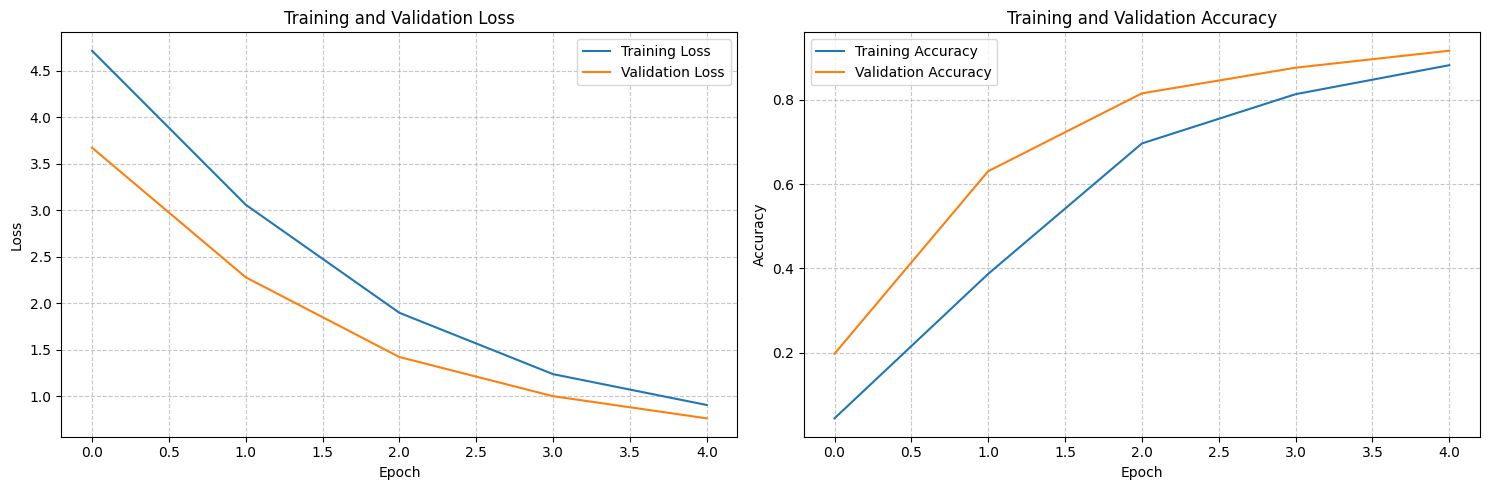

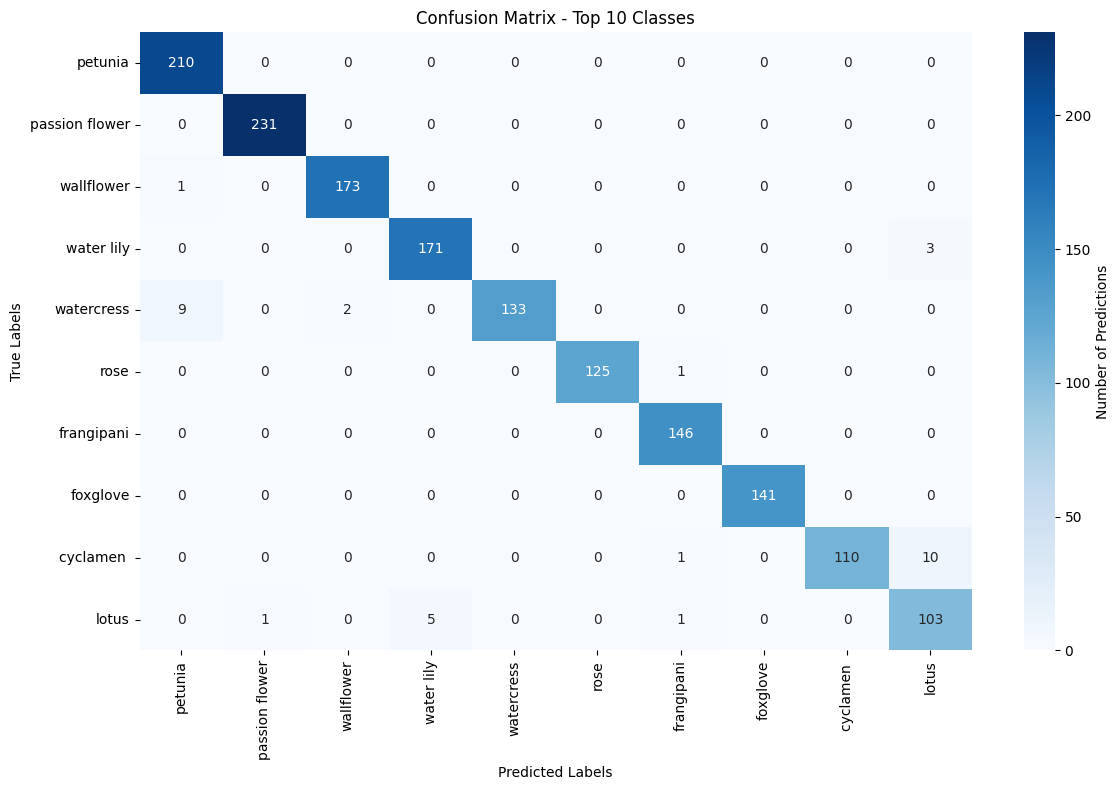

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.95      1.00      0.98       210
passion flower       1.00      1.00      1.00       231
    wallflower       0.99      0.99      0.99       174
    water lily       0.97      0.98      0.98       174
    watercress       1.00      0.92      0.96       144
          rose       1.00      0.99      1.00       126
    frangipani       0.98      1.00      0.99       146
      foxglove       1.00      1.00      1.00       141
     cyclamen        1.00      0.91      0.95       121
         lotus       0.89      0.94      0.91       110

      accuracy                           0.98      1577
     macro avg       0.98      0.97      0.98      1577
  weighted avg       0.98      0.98      0.98      1577



In [19]:
# Evaluate the vit on the test set
vit_prompt_tuned_test_loss, vit_prompt_tuned_test_acc, all_preds, all_labels = evaluate_model(vit_prompt_tuned, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {vit_prompt_tuned_test_acc:.4f}")
print(f"Final Test Loss: {vit_prompt_tuned_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(vit_prompt_tuned_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [ ]:
#visualization.visualize_misclassifications_with_closest_images(base_vit, data_loaders['test'], flower_labels, flowers_dataset['test'])